# Binary Image Segmentation
| The goal of this notebook is to implement a segmentation task that recognizes backgrounds in portrait images.

#| hide
## Step 0: setup

In [ ]:
#| hide
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
#| hide
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In [ ]:
from fastai.vision.all import *
assert torch.cuda.is_available()

## Step 1: Check the dataset

The dataset chosen for the task was the [AISegment.com Matting Human Datasets](https://www.kaggle.com/datasets/laurentmih/aisegmentcom-matting-human-datasets) due to its availability at Kaggle.

In [ ]:
path = Path("../input/aisegmentcom-matting-human-datasets")

The `path` contains a folder for the input image (`clip_img`) and another for the mattings (`matting`). Inside this folders, there are other folders and finally a file.  The leaf file in the `clip_img` subfolder has a correspondent one in the `matting` folder.  

As fastai `get_image_file` does not guarantee the order, we will need to sort them to garantee the correspondence.

In [ ]:
mattings = get_image_files(path/'matting').sorted()
images = get_image_files(path/'clip_img').sorted()
len(images)

34426

The dataset consist of 34426 images and their correspondent mattings. 

#### Opening image files

`fastai` uses `Pillow` to create images:

<AxesSubplot:>

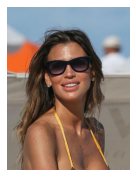

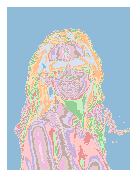

In [ ]:
img = PILImage.create(images[144])
mat = PILMask.create(mattings[144])
img.show(figsize=(3,3))
mat.show(figsize=(3,3))

Now, we will create a function to return a mask of codes, in the way MaskBlock expects.

In [ ]:
codes = np.array(['bg', 'fg'])
codes

array(['bg', 'fg'], dtype='<U2')

In [ ]:
def get_msk(fn):
    p = Path(str(fn).replace('clip', 'matting').replace('matting_img', 'matting').replace('.jpg', '.png'))
    msk = (tensor(PILImageBW.create(p))>0)*1
    msk = msk.to(torch.uint8)
    return PILMask.create(msk)

<AxesSubplot:>

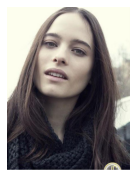

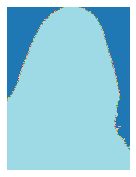

In [ ]:
f = images[4]
m = get_msk(f)
PILImage.create(f).show(figsize=(3,3))
PILMask.create(m).show(figsize=(3,3), alpha=1)

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [ ]:
dls = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   get_y=get_msk,
                   item_tfms=[Resize(192, method='squish')],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]).dataloaders(path/'clip_img', bs=8)

In [ ]:
dls.vocabs = codes
name2id = {v:k for k,v in enumerate(codes)}

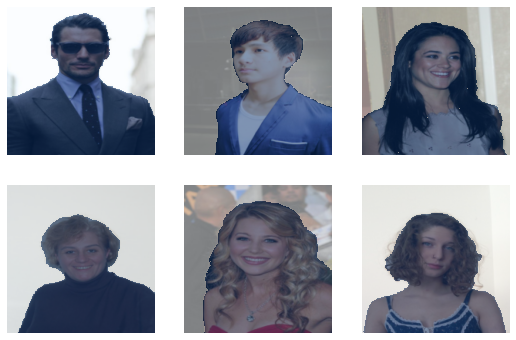

In [ ]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1, max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, MaskBlock),

The inputs to our model are images, and the outputs are Masks (a tensor of label codes).

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=get_mask,

The labels (`y` values) is obtained from the input filename by running the function `get_mask`.

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
Apply this list of transforms to each batch.  In this case, Normalize uses statistics from the imagenet dataset to normalize the data using imagenet as the sample. Normalization will try to distinguish values as much as possible, taking into account their occurrences in the sample.

In [ ]:
learn = unet_learner(dls, resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.055229,0.061927,22:33


epoch,train_loss,valid_loss,time
0,0.057066,0.059536,21:13
1,0.040231,0.055380,20:49
2,0.045216,0.051840,20:59


## Step 3: Use the model

Let's see what our model thinks about that bird we downloaded at the start:

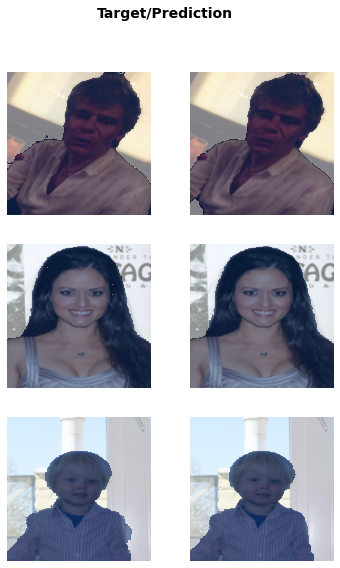

In [ ]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, max_n=3)

Now, we can export the model for later use:

In [ ]:
learn.export('bImgSeg.pkl')